In [1]:
import os
import digital_rf as drf
import numpy as np
import scipy as sp
import scipy.signal
from matplotlib import pyplot as plt

%matplotlib notebook

In [2]:
# Data settings
ch = 'ch0'
datadir = '/home/vtrung/data/crabneb_06aug18/'

# Pulsar properties
pulsar_period = 0.0333924123 # seconds
DM = 56.77118                # dispersion measure in parsec/cm^3
D = DM / 2.41e-4

# processing settings
nschs = 1024
nbins = 500

# set up reader
dro = drf.DigitalRFReader(datadir)
props = dro.get_properties(ch)
fs = props['samples_per_second']
ss, es = dro.get_bounds(ch)
meta = dro.get_digital_metadata(ch).read_latest().values()[0]
cfreq = meta['center_frequencies'][0]
bad_val = np.iinfo(np.int16).min + 1j*np.iinfo(np.int16).min

# derived values
channelized_samples_per_pulsar_period = pulsar_period*(fs / nschs)
sch_df = fs / nschs
sch_f0 = np.fft.fftfreq(nschs, 1/fs) + cfreq
sch_tds = D*((1e-6*(sch_f0 - sch_df))**(-2) - (1e-6*(sch_f0 + sch_df))**(-2))
nd = 2*int(np.ceil(max(sch_tds*(fs/nschs))))
noverlap = nd*nschs
ncoh = max(16, 2**(int(np.ceil(np.log2(nd)))))
nfft = ncoh*nschs
print(fs/nschs*pulsar_period)
nstep = nfft - noverlap
strides = (nstep*np.dtype(np.complex64).itemsize, np.dtype(np.complex64).itemsize)
read_length = int(np.floor(float(int(fs) - noverlap) / nstep))*nstep + noverlap
read_step = read_length - noverlap

fft_cfs = np.fft.ifftshift(np.fft.fftshift(np.fft.fftfreq(nschs*ncoh, 1/fs) + cfreq).reshape((nschs, ncoh)), axes=0)
df = fft_cfs[0, -1] - fft_cfs[0, 0]
sch_cfs = (fft_cfs[:, 0] + df/2).reshape((-1, 1)) # y-axis; subchannels of centre frequency
inv_dispersion = 1/np.exp(2*np.pi*1j*D*fft_cfs**2/(sch_cfs**2*(fft_cfs + sch_cfs)))
win = sp.signal.windows.blackmanharris(nfft, sym=False)

ValueError: No channels found: top_level_directory_arg = /home/vtrung/data/crabneb_06aug18/. If path is correct, you may need to run recreate_properties_file to re-create missing drf_properties.h5 files.

In [3]:
# Read data and fold at pulsar period into a given number of bins
last_output_sample = 0
folded = np.zeros((nbins, nschs), np.float32)
N = np.zeros(nbins, np.int64)
nchunks = int(np.ceil(float(es-ss)/read_step))
for k_chunk in range(nchunks):
    print('Data chunk {0}/{1}:'.format(k_chunk+1, nchunks))
    print('\tReading...')
    start_sample = ss + k_chunk*read_step
    nsamples = min(start_sample + read_length, es) - start_sample
    data = dro.read_vector(start_sample, nsamples, ch)
    # set dropped samples to zero in order to not mess with the statistics
    data[data == bad_val] = 0
    
    print('\tChannelizing and coherent dedispersion...')
    ndata = len(data)
    strided = np.lib.stride_tricks.as_strided(data, (ndata/nstep, nfft), strides, writeable=False)
    coh = np.fft.ifftshift(np.fft.fftshift(np.fft.fft(win*strided, axis=1), axes=1).reshape((-1, nschs, ncoh)), axes=1)
    dedisp = np.fft.ifft(coh*inv_dispersion, axis=2)[:, :, nd/2:-nd/2]
    schs = dedisp.swapaxes(1, 2).reshape((-1, nschs))
    
    print('\tFolding...')
    nsamps = len(schs)
    pulse_phase = ((np.r_[:nsamps] + last_output_sample) / channelized_samples_per_pulsar_period) % 1
    last_output_sample += nsamps
    fold_bin = np.int_(pulse_phase*nbins)
    np.add.at(N, fold_bin, 1)
    np.add.at(folded, fold_bin, schs.real**2 + schs.imag**2)

fname = os.path.join(datadir, ch + '-folded.npy')
print('Saving folded data to {0}'.format(fname))
np.save(fname, folded / N[:, np.newaxis])

Data chunk 1/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 2/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 3/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 4/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 5/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 6/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 7/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 8/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 9/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 10/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 11/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 12/3602:
	Reading...
	Channelizing and co

	Channelizing and coherent dedispersion...
	Folding...
Data chunk 96/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 97/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 98/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 99/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 100/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 101/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 102/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 103/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 104/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 105/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 106/3602:
	Reading...
	Channelizing and coherent dedispers

	Folding...
Data chunk 189/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 190/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 191/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 192/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 193/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 194/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 195/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 196/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 197/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 198/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 199/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 200/3602:

Data chunk 282/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 283/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 284/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 285/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 286/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 287/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 288/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 289/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 290/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 291/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 292/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 293/3602:
	Reading...

	Channelizing and coherent dedispersion...
	Folding...
Data chunk 376/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 377/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 378/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 379/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 380/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 381/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 382/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 383/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 384/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 385/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 386/3602:
	Reading...
	Channelizing and coherent dedis

	Folding...
Data chunk 469/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 470/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 471/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 472/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 473/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 474/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 475/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 476/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 477/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 478/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 479/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 480/3602:

Data chunk 562/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 563/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 564/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 565/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 566/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 567/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 568/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 569/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 570/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 571/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 572/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 573/3602:
	Reading...

	Channelizing and coherent dedispersion...
	Folding...
Data chunk 656/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 657/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 658/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 659/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 660/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 661/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 662/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 663/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 664/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 665/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 666/3602:
	Reading...
	Channelizing and coherent dedis

	Folding...
Data chunk 749/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 750/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 751/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 752/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 753/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 754/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 755/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 756/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 757/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 758/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 759/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 760/3602:

Data chunk 842/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 843/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 844/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 845/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 846/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 847/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 848/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 849/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 850/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 851/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 852/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 853/3602:
	Reading...

	Channelizing and coherent dedispersion...
	Folding...
Data chunk 936/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 937/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 938/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 939/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 940/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 941/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 942/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 943/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 944/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 945/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 946/3602:
	Reading...
	Channelizing and coherent dedis

	Channelizing and coherent dedispersion...
	Folding...
Data chunk 1029/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 1030/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 1031/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 1032/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 1033/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 1034/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 1035/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 1036/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 1037/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 1038/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 1039/3602:
	Reading...
	Channelizing and coh

	Folding...
Data chunk 1121/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 1122/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 1123/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 1124/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 1125/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 1126/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 1127/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 1128/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 1129/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 1130/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 1131/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chun

Data chunk 1213/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 1214/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 1215/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 1216/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 1217/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 1218/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 1219/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 1220/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 1221/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 1222/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 1223/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 1224/3602:

	Channelizing and coherent dedispersion...
	Folding...
Data chunk 1306/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 1307/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 1308/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 1309/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 1310/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 1311/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 1312/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 1313/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 1314/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 1315/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 1316/3602:
	Reading...
	Channelizing and coh

	Folding...
Data chunk 1398/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 1399/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 1400/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 1401/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 1402/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 1403/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 1404/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 1405/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 1406/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 1407/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 1408/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chun

Data chunk 1490/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 1491/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 1492/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 1493/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 1494/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 1495/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 1496/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 1497/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 1498/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 1499/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 1500/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 1501/3602:

	Channelizing and coherent dedispersion...
	Folding...
Data chunk 1583/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 1584/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 1585/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 1586/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 1587/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 1588/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 1589/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 1590/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 1591/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 1592/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 1593/3602:
	Reading...
	Channelizing and coh

	Folding...
Data chunk 1675/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 1676/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 1677/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 1678/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 1679/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 1680/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 1681/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 1682/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 1683/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 1684/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 1685/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chun

Data chunk 1767/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 1768/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 1769/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 1770/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 1771/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 1772/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 1773/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 1774/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 1775/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 1776/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 1777/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 1778/3602:

	Channelizing and coherent dedispersion...
	Folding...
Data chunk 1860/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 1861/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 1862/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 1863/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 1864/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 1865/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 1866/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 1867/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 1868/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 1869/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 1870/3602:
	Reading...
	Channelizing and coh

	Folding...
Data chunk 1952/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 1953/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 1954/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 1955/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 1956/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 1957/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 1958/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 1959/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 1960/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 1961/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 1962/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chun

Data chunk 2044/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 2045/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 2046/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 2047/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 2048/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 2049/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 2050/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 2051/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 2052/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 2053/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 2054/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 2055/3602:

	Channelizing and coherent dedispersion...
	Folding...
Data chunk 2137/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 2138/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 2139/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 2140/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 2141/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 2142/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 2143/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 2144/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 2145/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 2146/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 2147/3602:
	Reading...
	Channelizing and coh

	Folding...
Data chunk 2229/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 2230/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 2231/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 2232/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 2233/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 2234/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 2235/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 2236/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 2237/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 2238/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 2239/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chun

Data chunk 2321/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 2322/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 2323/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 2324/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 2325/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 2326/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 2327/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 2328/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 2329/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 2330/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 2331/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 2332/3602:

	Channelizing and coherent dedispersion...
	Folding...
Data chunk 2414/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 2415/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 2416/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 2417/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 2418/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 2419/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 2420/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 2421/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 2422/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 2423/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 2424/3602:
	Reading...
	Channelizing and coh

	Folding...
Data chunk 2506/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 2507/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 2508/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 2509/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 2510/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 2511/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 2512/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 2513/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 2514/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 2515/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 2516/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chun

Data chunk 2598/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 2599/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 2600/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 2601/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 2602/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 2603/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 2604/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 2605/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 2606/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 2607/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 2608/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 2609/3602:

	Channelizing and coherent dedispersion...
	Folding...
Data chunk 2691/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 2692/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 2693/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 2694/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 2695/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 2696/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 2697/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 2698/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 2699/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 2700/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 2701/3602:
	Reading...
	Channelizing and coh

	Folding...
Data chunk 2783/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 2784/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 2785/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 2786/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 2787/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 2788/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 2789/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 2790/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 2791/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 2792/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 2793/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chun

Data chunk 2875/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 2876/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 2877/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 2878/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 2879/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 2880/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 2881/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 2882/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 2883/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 2884/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 2885/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 2886/3602:

	Channelizing and coherent dedispersion...
	Folding...
Data chunk 2968/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 2969/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 2970/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 2971/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 2972/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 2973/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 2974/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 2975/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 2976/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 2977/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 2978/3602:
	Reading...
	Channelizing and coh

	Folding...
Data chunk 3060/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 3061/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 3062/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 3063/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 3064/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 3065/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 3066/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 3067/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 3068/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 3069/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 3070/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chun

Data chunk 3152/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 3153/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 3154/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 3155/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 3156/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 3157/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 3158/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 3159/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 3160/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 3161/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 3162/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 3163/3602:

	Channelizing and coherent dedispersion...
	Folding...
Data chunk 3245/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 3246/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 3247/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 3248/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 3249/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 3250/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 3251/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 3252/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 3253/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 3254/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 3255/3602:
	Reading...
	Channelizing and coh

	Folding...
Data chunk 3337/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 3338/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 3339/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 3340/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 3341/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 3342/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 3343/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 3344/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 3345/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 3346/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 3347/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chun

Data chunk 3429/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 3430/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 3431/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 3432/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 3433/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 3434/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 3435/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 3436/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 3437/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 3438/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 3439/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 3440/3602:

	Channelizing and coherent dedispersion...
	Folding...
Data chunk 3522/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 3523/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 3524/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 3525/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 3526/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 3527/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 3528/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 3529/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 3530/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 3531/3602:
	Reading...
	Channelizing and coherent dedispersion...
	Folding...
Data chunk 3532/3602:
	Reading...
	Channelizing and coh

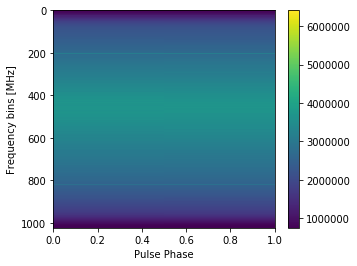

In [45]:
# read folded data
ch = 'ch0'
#fname = os.path.join('home/vtrung/Desktop/untitled', ch + '-folded.npy') #datadir, ch + '-folded.npy'
folded = np.load('ch0-folded.npy')
plt.figure()
plt.gcf().subplots_adjust(left=0.26)
plt.imshow(np.abs(np.fft.fftshift(folded, -1)).T, aspect='auto', interpolation='none')
plt.xlabel('Pulse Phase') # Figure out how to label pulse phase correctly
plt.xlim(0,1)
#plt.ylim([1410-16.6667/2,1410+16.6667/2])
#plt.axis([40, 160, 0, 0.03])
plt.ylabel('Frequency bins [MHz]')
plt.colorbar()
#plt.savefig('read_folded_data.pdf')

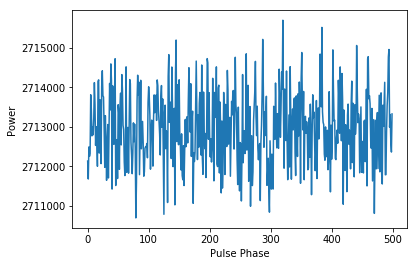

In [50]:
# sum up delayed frequency channels
summed = folded.mean(axis=1)
fig1=plt.figure()
plt.plot(np.abs(summed))
plt.xlabel('Pulse Phase')
plt.ylabel('Power')
plt.show()
fig1.savefig('sum_delayed_freqch.pdf')

Don't forget to add a label for the vertical axis on this plot. This looks like noise, which is consistent with your conclusion, but I don't understand what units this could be going from 2711000 to 2715000. If this is simply the squared sum of voltages, it's fine to say that it's proportional to power.  If that's what it is, you could also subtract off the average value so that the y-axis is centered at zero.

In [ ]:
# Remove all of lines (the evenly spaced lines) on the  first graph through excluding the data from the folded.mean
#, and maybe there will be a peak.
#       (Ryan doubts it though because there are not that much lines)

In [33]:
yf=np.linspace(1410+16.6667/2,1410-16.6667/2,5)
print yf
yfl=yf.tolist()
print yfl

[1418.33335  1414.166675 1410.       1405.833325 1401.66665 ]
[1418.33335, 1414.166675, 1410.0, 1405.833325, 1401.66665]


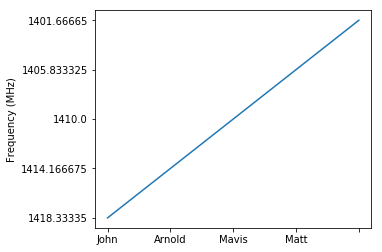

In [42]:
 x = np.array([0,1,2,3,4])
 y = np.array([20,21,22,23,24])
 fig5=plt.figure()
 my_xticks = ['John','Arnold','Mavis','Matt']
plt.gcf().subplots_adjust(left=0.26)
plt.tight_layout()
 plt.xticks(x, my_xticks)
 plt.yticks(y,yfl)
 plt.ylabel('Frequency (MHz)')
 plt.plot(x, y)
 plt.show()
 fig5.savefig('Fre.pdf')